## Compare salinometer and CTD salinities


In [1]:
import pandas as pd
import glob2
import numpy as np
import matplotlib.pyplot as plt

from CTD_funcs import station_niskin_from_sample_nr, station_niskin_from_sample_nr
from CTD_funcs import dataframe_sal

#### Connecting sample numbers with bottle numbers


In the salinometrr file, we have sample unique numbers a la *01, 02, ... 53*..

In the .btl files, we have sequential bottle numbers per cast, so *1, 2, 3..*

Linking these reference numbers to each other by reading rows containing both numbers in the big sample log excel sheet. 

In [2]:
basedir = '../data/'

sample_log_sheet_file =  f'{basedir}source/Samplelog_transect_tokt_2023_clean.xlsx'
salinometer_file = f'{basedir}new/salinometer/salinometer_values_tt2022_2023.csv'
#btl_files = glob2.glob(f'{basedir}new/bottle_data/*.csv')
btl_data_dir = f'{basedir}new/bottle_data/'

#### Read the sample log sheet

This sheet contains a bunch of information - we use it to connect sample numbers and station/cast/bottle.

In [3]:
df_log = pd.read_excel(sample_log_sheet_file)

#### Read salinometer data 

(Digitized from photos of handwritten log sheets)

In [4]:
DF = dataframe_sal(salinometer_file, df_log, btl_data_dir)

In [5]:
# Inspect the DataFrame:
#DF

# Analysis (data set specific)

#### Having a look at the data and dealing with some odd CTD measurements

First we look at the difference between the first and second conductivity and temperature senors:

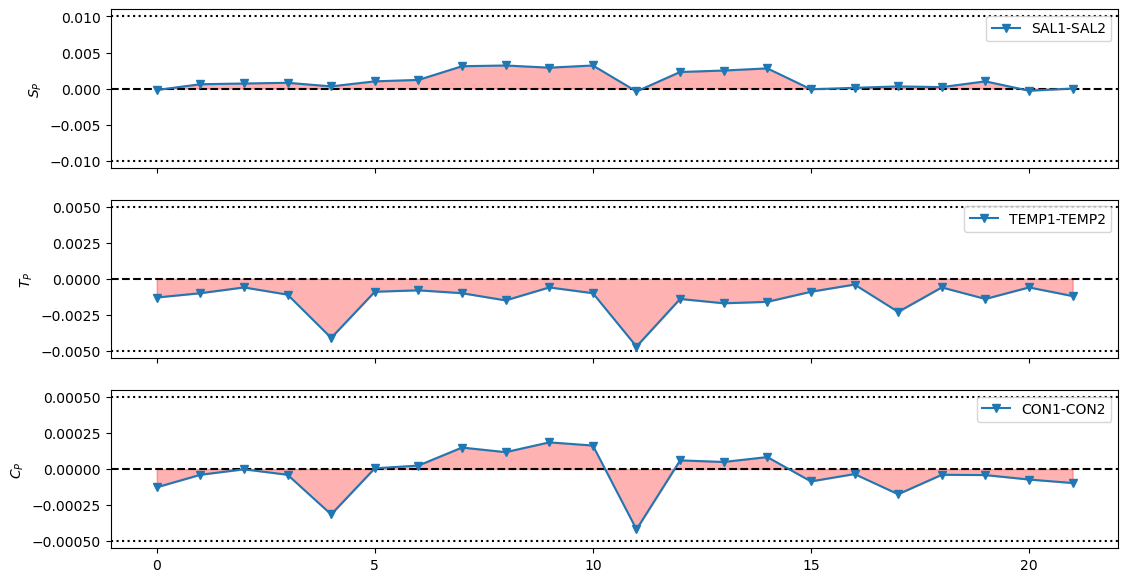

In [6]:
sample_index = np.arange(len(DF))

fig, ax = plt.subplots(3, 1, sharex = True, figsize = (13, 7))
ax[0].axhline(0, color = 'k', ls ='--')
ax[0].axhline(-0.01, color = 'k', ls =':')
ax[0].axhline(0.01, color = 'k', ls =':')

Sdiff_sensor = DF.S1_CTD-DF.S2_CTD
ax[0].plot(Sdiff_sensor,  'v-', label='SAL1-SAL2')
ax[0].fill_between(np.arange(len(DF)), Sdiff_sensor, color = 'r', alpha =0.3 )
ax[0].set_ylabel('$S_P$')
ax[0].legend()

ax[1].axhline(0, color = 'k', ls ='--')
ax[1].axhline(-0.005, color = 'k', ls =':')
ax[1].axhline(0.005, color = 'k', ls =':')

Tdiff_sensor = DF.T1_CTD-DF.T2_CTD
ax[1].plot(Tdiff_sensor,  'v-', label='TEMP1-TEMP2')
ax[1].fill_between(np.arange(len(DF)), Tdiff_sensor, color = 'r', alpha =0.3 )
ax[1].set_ylabel('$T_P$')
ax[1].legend()

ax[2].axhline(0, color = 'k', ls ='--')
ax[2].axhline(-0.0005, color = 'k', ls =':')
ax[2].axhline(0.0005, color = 'k', ls =':')

Cdiff_sensor = DF.C1_CTD-DF.C2_CTD
ax[2].plot(Cdiff_sensor,  'v-', label='CON1-CON2')
ax[2].fill_between(np.arange(len(DF)), Cdiff_sensor, color = 'r', alpha =0.3 )
ax[2].set_ylabel('$C_P$')
ax[2].legend()


OK, good. All differences are within sensor error bounds *(double-check those)*. Still, some systematic differences can be seen, let's find out if they impact the salinometer offsets.

First, we look at all values together to see if we have a *general* correspondence between CTD and salinometer: 

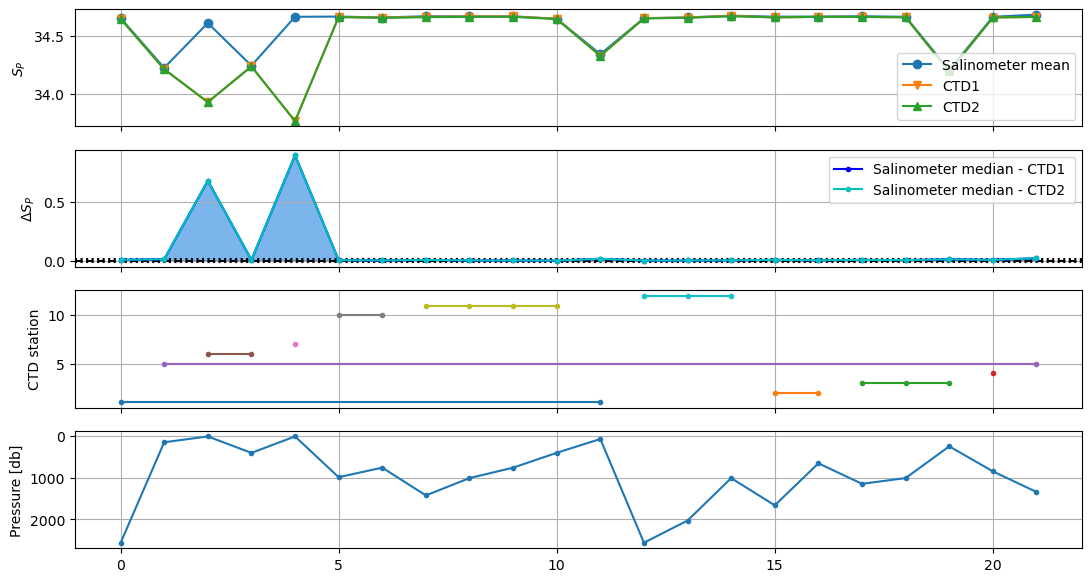

In [7]:
sample_index = np.arange(len(DF))

fig, ax = plt.subplots(4, 1, sharex = True, figsize = (13, 7))
ax[0].plot(DF.S_final, 'o-', label='Salinometer mean')
ax[0].plot(DF.S1_CTD,  'v-', label='CTD1')
ax[0].plot(DF.S2_CTD,  '^-', label='CTD2')
ax[0].set_ylabel('$S_P$')
ax[0].legend()

Sdiff1 = np.ma.masked_invalid(np.float_((DF.S_final.values - DF.S1_CTD).values))
Sdiff2 = np.ma.masked_invalid(np.float_((DF.S_final.values - DF.S2_CTD).values))
ax[1].axhline(0, color = 'k', ls ='--')
ax[1].axhline(-0.01, color = 'k', ls =':')
ax[1].axhline(0.01, color = 'k', ls =':')

ax[1].plot(Sdiff1, '.-b', label='Salinometer median - CTD1 ')
ax[1].plot(Sdiff1, '.-c', label='Salinometer median - CTD2 ')
ax[1].fill_between(np.arange(len(DF)), Sdiff1, color = 'b', alpha =0.3 )
ax[1].fill_between(np.arange(len(DF)), Sdiff2, color = 'c', alpha =0.3 )
ax[1].set_ylabel('$\Delta S_P$')

for station_ in np.unique(DF.CTD_station):
    DF_st = DF[DF.CTD_station == station_]
    ax[2].plot(DF_st.CTD_station, '.-')
ax[2].set_ylabel('CTD station')


ax[3].plot(DF.p_CTD, '.-')
ax[3].set_ylabel('Pressure [db]')

ax[3].invert_yaxis()

ax[0].legend(); ax[1].legend()
for axn in ax:
    axn.grid()

### Removing shallow samples

In addition, we want to reduce samples taken in sections of the profile with string gradients, etc.

-> **Dropping samples from shallower than 500 m** so we can be more confident that we only look at samples from stable water masses.

In [8]:
DF_deep = DF[DF.p_CTD>500].reset_index(drop=True)

## Redoing the comparison plot with the reduced dataset

Also adding some more useful stuff to the plot.

Paul D: uses 0.01 as an effective threshold for judging when a salinity measurement is "suspicious"..

In [9]:
DF_deep['Sdiff1'] = np.ma.masked_invalid(np.float_((DF_deep.S_final.values - DF_deep.S1_CTD).values))
DF_deep['Sdiff2'] = np.ma.masked_invalid(np.float_((DF_deep.S_final.values - DF_deep.S2_CTD).values))

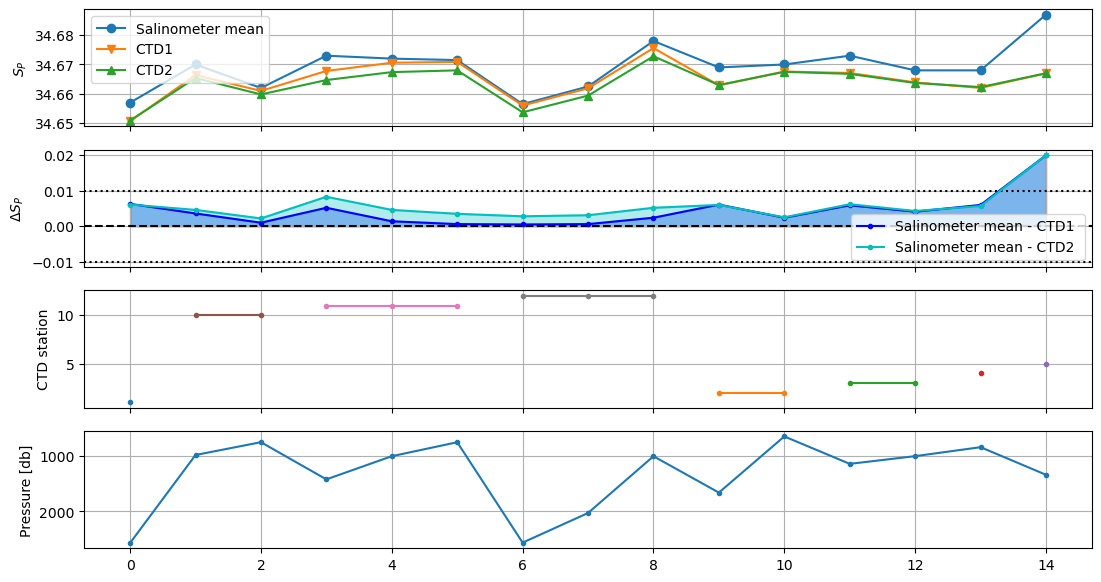

In [10]:
sample_index = np.arange(len(DF_deep))

fig, ax = plt.subplots(4, 1, sharex = True, figsize = (13, 7))
ax[0].plot(DF_deep.S_final, 'o-', label='Salinometer mean')
ax[0].plot(DF_deep.S1_CTD,  'v-', label='CTD1')
ax[0].plot(DF_deep.S2_CTD,  '^-', label='CTD2')
ax[0].set_ylabel('$S_P$')
ax[0].legend()

ax[1].axhline(0, color = 'k', ls ='--')
ax[1].axhline(-0.01, color = 'k', ls =':')
ax[1].axhline(0.01, color = 'k', ls =':')

ax[1].plot(DF_deep['Sdiff1'], '.-b', label='Salinometer mean - CTD1 ')
ax[1].plot(DF_deep['Sdiff2'], '.-c', label='Salinometer mean - CTD2 ')
ax[1].fill_between(np.arange(len(DF_deep)), DF_deep.Sdiff1, color = 'b', alpha =0.3 )
ax[1].fill_between(np.arange(len(DF_deep)), DF_deep.Sdiff2, color = 'c', alpha =0.3 )
ax[1].set_ylabel('$\Delta S_P$')

for station_ in np.unique(DF_deep.CTD_station):
    DF_deep_st = DF_deep[DF_deep.CTD_station == station_]
    ax[2].plot(DF_deep_st.CTD_station, '.-')
ax[2].set_ylabel('CTD station')


ax[3].plot(DF_deep.p_CTD, '.-')
ax[3].set_ylabel('Pressure [db]')

ax[3].invert_yaxis()

ax[0].legend(); ax[1].legend()
for axn in ax:
    axn.grid()

#fig.savefig('/home/oyvindl/work/salinometer_vs_CTD_TT2021.png')

All within Paul's "effective threshold" of 0.01, except last value. Suspicious salinity increase of salinometer value... See also that offset to salinometer decreases for the second sensor for periods when sensors differ more. Should select the second line as the primary data source for netcdf creation.

Might want to look if last profile differs much from the previous ones in the deep water masses, then possibly adjust, but likely not and then regarding that salinometer value as outlier. 